In [708]:
# imports
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# PART A: Read-in and EDA

In [709]:
# Data downloaded from: https://www.kaggle.com/datasets/manjeetsingh/retaildataset/data

features_data_set = pd.read_csv(r"C:\Users\ryan.mcneil\Documents\Projects\CSC84040\retail_data_analytics\Features data set.csv")
sales_data_set = pd.read_csv(r"C:\Users\ryan.mcneil\Documents\Projects\CSC84040\retail_data_analytics\sales data-set.csv")
stores_data_set = pd.read_csv(r"C:\Users\ryan.mcneil\Documents\Projects\CSC84040\retail_data_analytics\stores data-set.csv")

In [710]:
features_data_set.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


features_data_set appears to be a dataset of stores with data by date for each store including average temperature, gas prices, data on promotional markdowns, the CPI and unemployment rates on that date and whether that date was a holiday.

In [711]:
sales_data_set.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


This dataset includes data by store and by department on weekly sales and whether each date was a holiday.

In [712]:
stores_data_set.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


The stores_data_set appears to contain additional data about stores, including their size and type. The exact meaning of these variables is not immediately clear, and the Kaggle page does not provide additional context. 
Next I add our seasonality features.

In [713]:
sales_data_set['Date'] = pd.to_datetime(sales_data_set['Date'], format="%d/%m/%Y")
features_data_set['Date'] = pd.to_datetime(features_data_set['Date'], format="%d/%m/%Y")

sales_data_set['month'] = sales_data_set['Date'].dt.month
sales_data_set['day'] = sales_data_set['Date'].dt.day
sales_data_set['year'] = sales_data_set['Date'].dt.year

features_data_set['month'] = features_data_set['Date'].dt.month
features_data_set['day'] = features_data_set['Date'].dt.day
features_data_set['year'] = features_data_set['Date'].dt.year

In [714]:
sales_data_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,month,day,year
0,1,1,2010-02-05,24924.50,False,2,5,2010
1,1,1,2010-02-12,46039.49,True,2,12,2010
2,1,1,2010-02-19,41595.55,False,2,19,2010
3,1,1,2010-02-26,19403.54,False,2,26,2010
4,1,1,2010-03-05,21827.90,False,3,5,2010


We now have month, day, and year features in our features and sales datasets.

In [715]:
stores_data_set

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [716]:
# Sort by Store, then date, then dept.
sales_data_set = sales_data_set.sort_values(by=['Store', 'Date', 'Dept']).reset_index(drop=True)

# Group by store and date then aggregate weekly sales by summing and IsHoliday by 'any' (evals to True for any value in group = True).
sales_by_store = sales_data_set.groupby(['Store', 'Date']).agg({'Weekly_Sales': 'sum', 'IsHoliday': 'any'}).reset_index()

# We then create the month day and year features from date.
sales_by_store['month'] = sales_by_store['Date'].dt.month
sales_by_store['day'] = sales_by_store['Date'].dt.day
sales_by_store['year'] = sales_by_store['Date'].dt.year

# We merge sales_by_store on stores_data_set for type and size features.
sales_by_store = pd.merge(sales_by_store, 
                          stores_data_set, 
                          on='Store')

sales_by_store.describe()

,Store,Date,Weekly_Sales,month,day,year,Size
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,6.447552,15.678322,2010.965035,130287.600000
min,1.000000,2010-02-05 00:00:00,2.099862e+05,1.000000,1.000000,2010.000000,34875.000000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,4.000000,8.000000,2010.000000,70713.000000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,6.000000,16.000000,2011.000000,126512.000000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,9.000000,23.000000,2012.000000,202307.000000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,12.000000,31.000000,2012.000000,219622.000000
std,12.988182,NaN,5.643666e+05,3.238308,8.755780,0.797019,63117.022465


Visualization

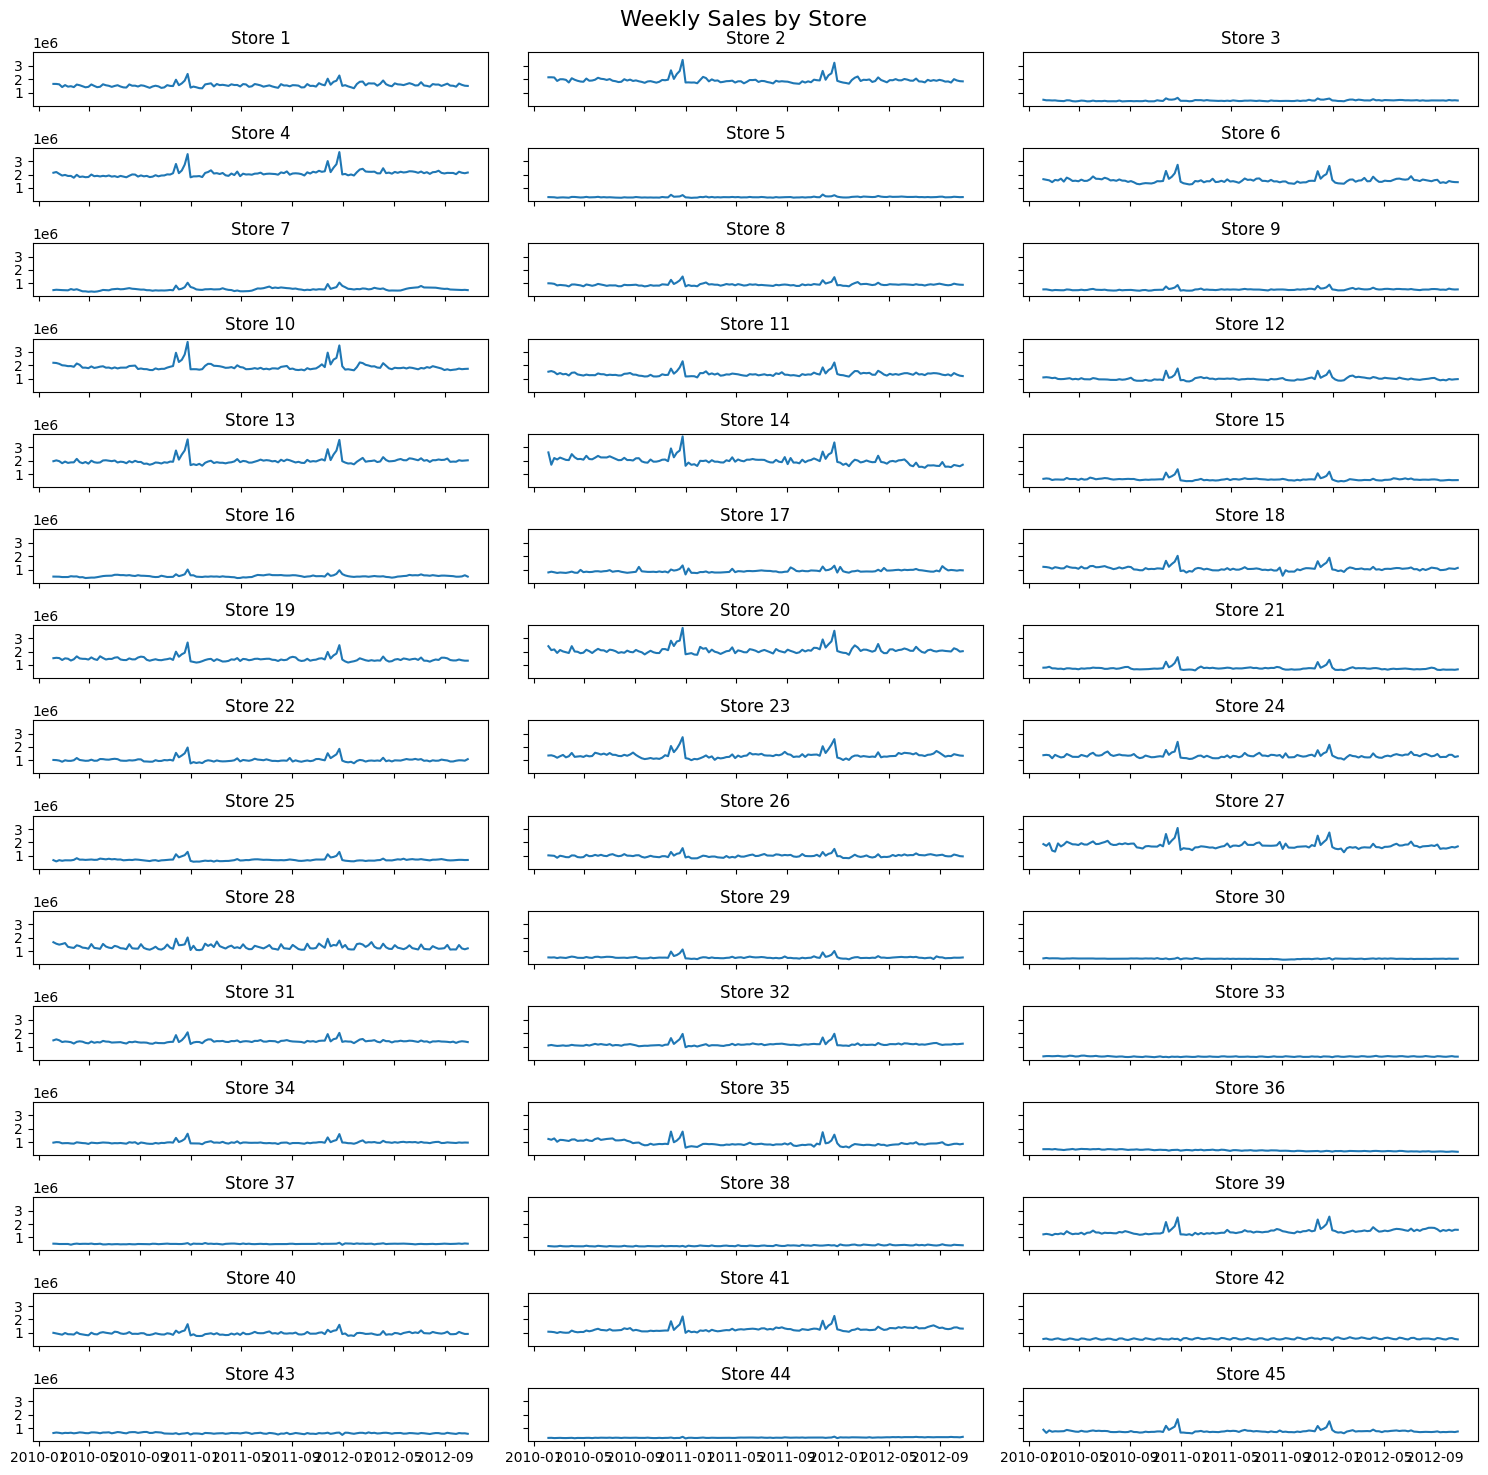

In [717]:
# Calculate grid dimensions
num_stores = sales_by_store['Store'].nunique()
num_cols = 3  # You can adjust the number of columns
num_rows = math.ceil(num_stores / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, 
                         num_cols, 
                         figsize=(15, 15), 
                         sharex=True, 
                         sharey=True)  # Adjust figsize as needed
fig.suptitle('Weekly Sales by Store', 
             fontsize=16)

# Iterate through stores and plot
store_num = 1
for i in range(num_rows):
    for j in range(num_cols):
        if store_num <= num_stores:
            ax = axes[i, j]
            store_data = sales_by_store[sales_by_store['Store'] == store_num]
            ax.plot(store_data['Date'], store_data['Weekly_Sales'])
            ax.set_title(f'Store {store_num}')
            store_num += 1
        else:
            ax.axis('off')  # Hide empty subplots

plt.tight_layout()  # Adjust subplot spacing
plt.show()

Most stores appear to have periodic peaks around November/December of each year: one initial spike usually followed by another larger spike. Possibly a holiday rush.

# Fit VAR Model

In [718]:
multi_data = sales_by_store.pivot(index='Date', 
                                  columns='Store', 
                                  values='Weekly_Sales')
multi_data

Store,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1643690.90,2136989.46,461622.22,2135143.87,317173.10,1652635.10,496725.44,1004137.09,549505.55,2193048.75,...,467546.74,536006.73,358496.14,1230596.80,1001943.80,1086533.18,543384.01,647029.28,281090.95,890689.51
2010-02-12,1641957.44,2137809.50,420728.96,2188307.39,311825.70,1606283.86,524104.92,994801.40,552677.48,2176028.52,...,469563.70,529852.70,342214.90,1266229.07,955338.29,1075656.34,575709.96,682918.99,286857.13,656988.64
2010-02-19,1611968.17,2124451.54,421642.19,2049860.26,303447.57,1567138.07,506760.54,963960.37,511327.90,2113432.58,...,470281.03,510382.50,327237.92,1230591.97,916289.20,1052034.74,508794.87,658997.55,267956.30,841264.04
2010-02-26,1409727.59,1865097.27,407204.86,1925728.84,270281.63,1432953.21,496083.24,847592.11,473773.27,2006774.96,...,447519.44,513615.82,334222.73,1168582.02,863917.41,991941.73,491510.58,618702.79,273079.07,741891.65
2010-03-05,1554806.68,1991013.13,415202.04,1971057.44,288855.71,1601348.82,491419.55,881503.95,507297.88,1987090.09,...,480203.43,519255.68,372239.89,1266254.21,990152.28,1063557.49,554972.42,658600.05,284617.27,777951.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1437059.26,1746470.56,389813.02,2027620.23,310141.68,1369131.46,525545.76,884724.41,516361.06,1694862.41,...,270677.98,527953.14,398468.08,1495607.07,919595.44,1307928.01,505978.46,577792.32,355307.94,713173.95
2012-10-05,1670785.97,1998321.04,443557.65,2209835.43,343048.29,1518177.71,505830.56,976436.02,606755.30,1758971.38,...,277137.86,546122.37,458479.01,1574408.67,1069112.00,1400160.95,593162.53,642614.89,337390.44,733455.07
2012-10-12,1573072.81,1900745.13,410804.39,2133026.07,325345.41,1459396.84,503463.93,927511.99,558464.80,1713889.11,...,300236.85,521810.75,437320.66,1494417.07,982523.26,1409544.97,612379.90,619369.72,337796.13,734464.36


In [719]:
model = VAR(multi_data)
model_fit = model.fit()

In [720]:
multi_data_clipped = pd.DataFrame(multi_data.iloc[-12:, :])
multi_data_clipped

Store,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-10,1592409.97,1866719.96,391811.60,2193367.69,306759.70,1588380.73,675926.30,930745.69,538713.47,1880436.94,...,298947.51,500964.59,436690.13,1641867.92,1007906.43,1504545.94,576620.31,643558.78,333594.81,733037.32
2012-08-17,1597868.05,1928016.01,394918.83,2283540.30,314014.18,1543049.52,642450.40,896613.19,535153.47,1827797.40,...,314607.22,509633.71,411866.46,1720221.91,969387.48,1560590.05,575997.78,640210.85,327389.51,722496.93
2012-08-24,1494122.38,1876788.15,412449.67,2125241.68,320831.36,1501095.49,609099.37,936373.65,572887.78,1764984.15,...,282545.55,522665.04,397428.22,1724669.75,945318.47,1464462.85,535537.03,598234.64,337985.74,718232.26
2012-08-31,1582083.40,1947083.30,408838.73,2081181.35,344642.01,1577439.81,586467.16,976137.73,576879.15,1650285.54,...,282647.48,538344.10,424904.95,1710923.94,987264.67,1360517.52,504760.57,593141.29,339490.69,734297.87
2012-09-07,1661767.33,1898777.07,408229.73,2125104.72,350648.91,1608077.01,597876.55,932160.37,565812.29,1708283.28,...,293728.57,526838.14,490274.82,1609811.75,1088248.40,1392143.82,617405.35,663814.18,338737.33,766512.66
2012-09-14,1517428.87,1814806.63,407589.16,2117854.60,299800.67,1375166.86,541120.20,883569.38,523427.35,1640168.99,...,301893.63,514651.74,430944.39,1447614.08,901709.82,1306644.25,586737.66,625196.94,347726.67,702238.27
2012-09-21,1506126.06,1829415.67,414392.09,2119438.53,307306.76,1425603.65,530842.25,857796.45,533756.88,1671857.57,...,293804.45,521320.98,409600.98,1555672.51,899768.40,1276609.36,527165.70,601990.02,336017.60,723086.20
2012-09-28,1437059.26,1746470.56,389813.02,2027620.23,310141.68,1369131.46,525545.76,884724.41,516361.06,1694862.41,...,270677.98,527953.14,398468.08,1495607.07,919595.44,1307928.01,505978.46,577792.32,355307.94,713173.95
2012-10-05,1670785.97,1998321.04,443557.65,2209835.43,343048.29,1518177.71,505830.56,976436.02,606755.30,1758971.38,...,277137.86,546122.37,458479.01,1574408.67,1069112.00,1400160.95,593162.53,642614.89,337390.44,733455.07


In [721]:
forecast = model_fit.forecast(multi_data_clipped.values, 
                              steps=12)

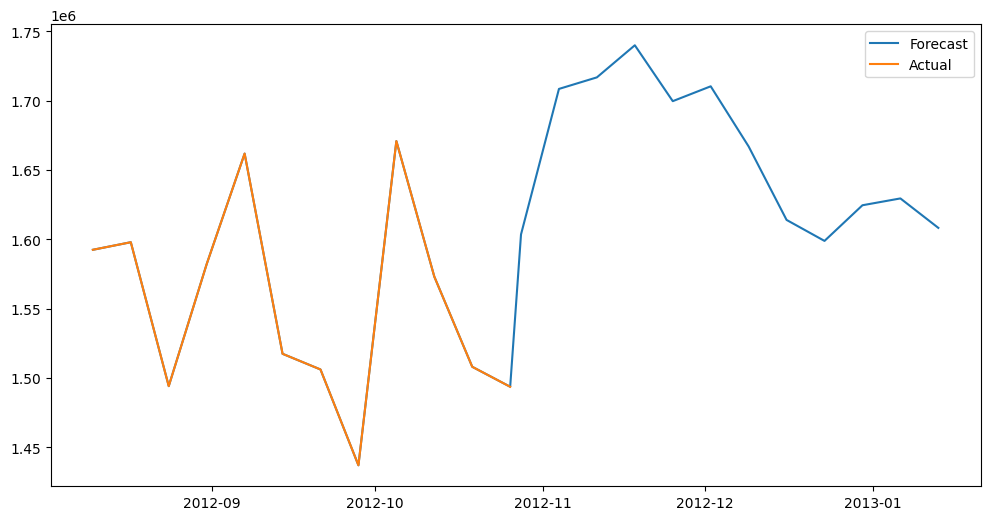

In [722]:
store_id = 1 # store number 1 through 45
# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(list(multi_data_clipped.index)+ 
            list(pd.date_range(start=multi_data_clipped.index[-1], 
                               periods=12, 
                               freq='W')), 
         list(multi_data_clipped.values[:,store_id-1]) + 
            list(forecast[:,store_id-1]), 
                 label='Forecast')
plt.plot(list(multi_data_clipped.index), 
         list(multi_data_clipped.values[:,store_id-1]), 
              label='Actual')
plt.legend()
plt.show()

# Build Statistical Models

Start by assessing stationarity with an Augmented Dickey-Fuller (ADF) test. Some background research suggested that a threshold of 0.1 is lenient, so I reduce to 0.05 and experiment. This is a stricter criteria, providing us more confidence in the stationarity of all other stores, while only adding 1 additional store to our list of non-stationary stores. I also save the non-stationary stores for later.

In [723]:
unique_stores = sales_by_store['Store'].unique()
nonstationary_stores = []

for store in unique_stores:
    # Get store
    store_data = sales_by_store[sales_by_store['Store'] == store]
    # Get just weekly sales indexed by date
    ts = store_data.set_index('Date')['Weekly_Sales']
    # Run test on store
    result = adfuller(ts)
    if result[1] >.05 : # Lower criteria
        print(f"Store {store} is NOT stationary with p-value {result[1]}")
        # Save non-stationary stores to list
        nonstationary_stores.append(int(store))

Store 14 is NOT stationary with p-value 0.06786986708375113
Store 30 is NOT stationary with p-value 0.16836387986791795
Store 36 is NOT stationary with p-value 0.9730158839006193
Store 38 is NOT stationary with p-value 0.9165634765957096
Store 42 is NOT stationary with p-value 0.4572851622571738
Store 43 is NOT stationary with p-value 0.10605876999786595
Store 44 is NOT stationary with p-value 0.7591618635707302


Only a few stores are not stationary. These may be stores seeing continual growth or decline in business over the course of time in our dataset.

From class: "We can do ARIMA(1,0,0) for most stores and ARIMA(1,1,0) for those failures."

In detail:
* The first term, p, accounts for the number fo autoregressive terms. We would be predicting future values based on only one lagged term, one could do more, but for the purposes of this assignment, 1 should be sufficient. 
* The second term, d, determines the differencing applied to the series to compensate for non-stationarity. If the series is already stationary, d can be set to 0. However, for non-stationary series, it is useful to set d to 1 (differencing once). 
* The third term, q, is the number of moving average terms. That is, how many past forecast errors are used to predict the future value. This term can help account for random shocks or errors. My interpretation is that you say we should leave q=0 because the two peaks we see in the time data are periodic, not random, and that we otherwise do not see major random shocks in our data.

# Part B: ARIMA Models

I start with the class example AR model. I include use of d terms for non-stationary stores.

In [724]:
# Splits data into train(first 90%) and test (last 10%)
unique_dates = sales_by_store['Date'].unique()
unique_dates = np.sort(unique_dates)
train_dates = unique_dates[:int(0.9*len(unique_dates))]
test_dates = unique_dates[int(0.9*len(unique_dates)):]

In [725]:
arima_models = {}

# Fit and save our models
for store in unique_stores:
    store_data = sales_by_store[np.logical_and(sales_by_store['Store'] == store, sales_by_store['Date'].isin(train_dates))]
    ts = store_data.set_index('Date')['Weekly_Sales']
    if store in nonstationary_stores:
        model = ARIMA(ts, order=(1, 1, 0))
        print(f"Store {store} model fit with p=1, d=1, q=0")
    else:
        print(f"Store {store} model fit with p=1, d=0, q=0")
        model = ARIMA(ts, order=(1, 0, 0))
    model_fit = model.fit()
    arima_models[store] = model_fit


Store 1 model fit with p=1, d=0, q=0
Store 2 model fit with p=1, d=0, q=0
Store 3 model fit with p=1, d=0, q=0
Store 4 model fit with p=1, d=0, q=0
Store 5 model fit with p=1, d=0, q=0
Store 6 model fit with p=1, d=0, q=0
Store 7 model fit with p=1, d=0, q=0
Store 8 model fit with p=1, d=0, q=0
Store 9 model fit with p=1, d=0, q=0
Store 10 model fit with p=1, d=0, q=0
Store 11 model fit with p=1, d=0, q=0
Store 12 model fit with p=1, d=0, q=0
Store 13 model fit with p=1, d=0, q=0
Store 14 model fit with p=1, d=1, q=0
Store 15 model fit with p=1, d=0, q=0
Store 16 model fit with p=1, d=0, q=0
Store 17 model fit with p=1, d=0, q=0
Store 18 model fit with p=1, d=0, q=0
Store 19 model fit with p=1, d=0, q=0
Store 20 model fit with p=1, d=0, q=0
Store 21 model fit with p=1, d=0, q=0
Store 22 model fit with p=1, d=0, q=0
Store 23 model fit with p=1, d=0, q=0
Store 24 model fit with p=1, d=0, q=0
Store 25 model fit with p=1, d=0, q=0
Store 26 model fit with p=1, d=0, q=0
Store 27 model fit wi

In [726]:
#Inspect one
arima_models[14].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1781.547
Date:                Wed, 11 Dec 2024   AIC                           3567.093
Time:                        18:02:57   BIC                           3572.782
Sample:                    02-05-2010   HQIC                          3569.404
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4319      0.031    -13.720      0.000      -0.494      -0.370
sigma2      8.973e+10   1.13e-13   7.96e+23      0.000    8.97e+10    8.97e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               676.98
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.1e+39. Standard errors may be unstable.
"""

I prepare a lag term.

In [727]:
sales_by_store['Weekly_Sales_lag1'] = sales_by_store.groupby('Store')['Weekly_Sales'].shift(1)

AR output amended to correctly calculate with d term for non-stationary stores. Models produced with d=1 have no 'const' parameter.

In [728]:
# create 1 week ahead prediction for each store and
for idx, row in sales_by_store[sales_by_store['Date'].isin(test_dates)].iterrows():
    store = row['Store']

    model = arima_models[store]
    # apply model to Weekly_Sales_lag1
    if "const" in model.params:
        forecast = model.params['const'] + row['Weekly_Sales_lag1'] * model.params['ar.L1']
    else:
        forecast = row['Weekly_Sales_lag1'] * model.params['ar.L1']
    sales_by_store.loc[idx, 'forecast'] = forecast
    if "const" in model.params:
        sales_by_store.loc[idx,'intercept'] = model.params['const']
    sales_by_store.loc[idx,'rho'] = model.params['ar.L1']

sales_by_store[sales_by_store['Date'].isin(test_dates)]

,Store,Date,Weekly_Sales,IsHoliday,month,day,year,Type,Size,Weekly_Sales_lag1,forecast,intercept,rho
128,1,2012-07-20,1497954.76,False,7,20,2012,A,151315,1527014.04,2.026667e+06,1.556251e+06,0.308062
129,1,2012-07-27,1439123.71,False,7,27,2012,A,151315,1497954.76,2.017715e+06,1.556251e+06,0.308062
130,1,2012-08-03,1631135.79,False,8,3,2012,A,151315,1439123.71,1.999591e+06,1.556251e+06,0.308062
131,1,2012-08-10,1592409.97,False,8,10,2012,A,151315,1631135.79,2.058743e+06,1.556251e+06,0.308062
132,1,2012-08-17,1597868.05,False,8,17,2012,A,151315,1592409.97,2.046813e+06,1.556251e+06,0.308062
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,False,9,28,2012,B,118221,723086.20,1.062119e+06,7.926635e+05,0.372646
6431,45,2012-10-05,733455.07,False,10,5,2012,B,118221,713173.95,1.058425e+06,7.926635e+05,0.372646
6432,45,2012-10-12,734464.36,False,10,12,2012,B,118221,733455.07,1.065983e+06,7.926635e+05,0.372646
6433,45,2012-10-19,718125.53,False,10,19,2012,B,118221,734464.36,1.066359e+06,7.926635e+05,0.372646


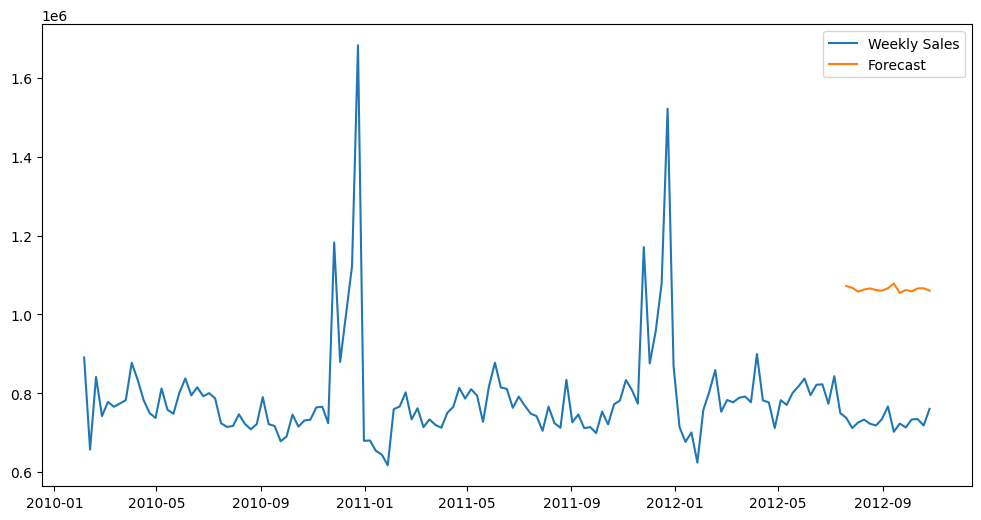

In [729]:
# plot weekly sales and forecast for store 45
plt.figure(figsize=(12,6))
plt.plot(sales_by_store[sales_by_store['Store'] == 45]['Date'], sales_by_store[sales_by_store['Store'] == 45]['Weekly_Sales'], label='Weekly Sales')
plt.plot(sales_by_store[sales_by_store['Store'] == 45]['Date'], sales_by_store[sales_by_store['Store'] == 45]['forecast'], label='Forecast')
plt.legend()
plt.show()

AR model overpredicts sales because it is considering the entire time series at prediction time. You can see that the forecast is pulled upwards by the peaks.

In [730]:
mae = mean_absolute_error(sales_by_store[sales_by_store['Date'].isin(test_dates)]['Weekly_Sales'], sales_by_store[sales_by_store['Date'].isin(test_dates)]['forecast'])
print('MAE:', mae)

MAE: 489007.58551929315


# Now, I predict with actual ARIMA, using the 'forecast' method
First I drop the lag term and previous predictions.

In [731]:
sales_by_store2 = sales_by_store.drop(["Weekly_Sales_lag1", "forecast", "intercept", 'rho'], axis=1)

In [732]:
# Create 1-week ahead predictions for test_dates
for idx, row in sales_by_store2[sales_by_store2['Date'].isin(test_dates)].iterrows():
    # Retrieve the ARIMA model for the specific store
    store = row['Store']
    model = arima_models[store]
    
    # Get current date
    current_date = row['Date']

    # Get a 1-week ahead forecast for the current row's date
    forecast = model.predict(start=current_date + pd.Timedelta(weeks=1), end=current_date + pd.Timedelta(weeks=1))
    
    # Store the forecast in the DataFrame
    sales_by_store2.loc[idx, 'forecast'] = forecast[0]

    if "const" in model.params:
        sales_by_store2.loc[idx, 'intercept'] = model.params['const']
    sales_by_store2.loc[idx, 'rho'] = model.params.get('ar.L1', None)


In [733]:
# Output results for test dates
sales_by_store2[sales_by_store2['Date'].isin(test_dates)]

,Store,Date,Weekly_Sales,IsHoliday,month,day,year,Type,Size,forecast,intercept,rho
128,1,2012-07-20,1497954.76,False,7,20,2012,A,151315,1.553476e+06,1.556251e+06,0.308062
129,1,2012-07-27,1439123.71,False,7,27,2012,A,151315,1.555396e+06,1.556251e+06,0.308062
130,1,2012-08-03,1631135.79,False,8,3,2012,A,151315,1.555988e+06,1.556251e+06,0.308062
131,1,2012-08-10,1592409.97,False,8,10,2012,A,151315,1.556170e+06,1.556251e+06,0.308062
132,1,2012-08-17,1597868.05,False,8,17,2012,A,151315,1.556226e+06,1.556251e+06,0.308062
...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,False,9,28,2012,B,118221,7.926632e+05,7.926635e+05,0.372646
6431,45,2012-10-05,733455.07,False,10,5,2012,B,118221,7.926634e+05,7.926635e+05,0.372646
6432,45,2012-10-12,734464.36,False,10,12,2012,B,118221,7.926634e+05,7.926635e+05,0.372646
6433,45,2012-10-19,718125.53,False,10,19,2012,B,118221,7.926635e+05,7.926635e+05,0.372646


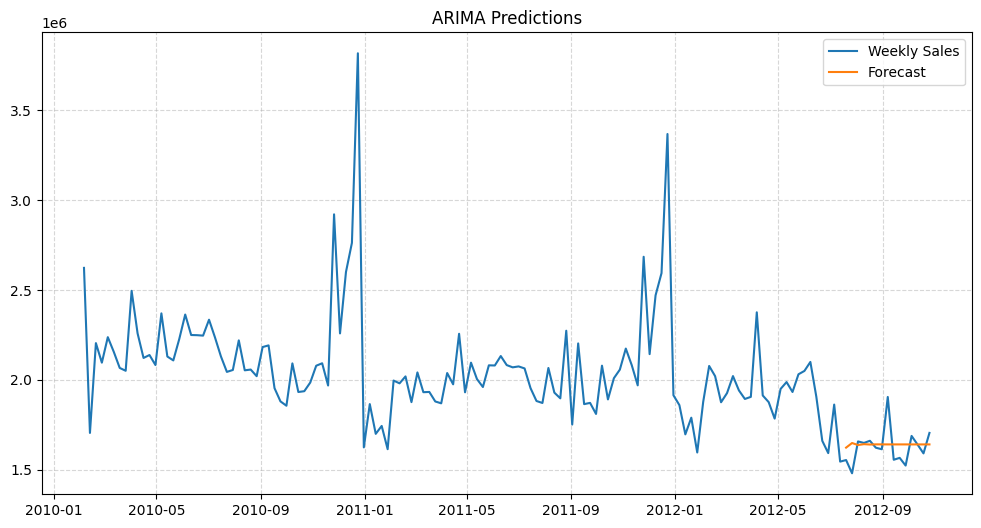

In [734]:
store = 14

plt.figure(figsize=(12,6))
plt.title("ARIMA Predictions")
plt.plot(sales_by_store2[sales_by_store2['Store'] == store]['Date'], sales_by_store2[sales_by_store2['Store'] == store]['Weekly_Sales'], label='Weekly Sales')
plt.plot(sales_by_store2[sales_by_store2['Store'] == store]['Date'], sales_by_store2[sales_by_store2['Store'] == store]['forecast'], label='Forecast')
plt.grid(True, alpha=0.5, linestyle="--")
plt.legend()
plt.show()

Calculate mean absolute error and take the mean and median.

In [735]:
MAEs = []

for store in unique_stores:
    store_data = sales_by_store[sales_by_store['Store'] == store]
    mae = mean_absolute_error(store_data[store_data['Date'].isin(test_dates)]['Weekly_Sales'], store_data[store_data['Date'].isin(test_dates)]['forecast'])
    mean = store_data["forecast"].mean()
    median = store_data["forecast"].median()
    MAEs.append(mae)
    if mae > 500000:
        print("*")
    print("Store: ", store)
    if store in nonstationary_stores:
        print(f'Nonstationary')
    else:
        print(f'Stationary')
    print(f'MAE: {mae}')
    print(f'Mean: {mean}')
    print(f'Median: {median}')
    print("\n")

print("Mean MAE: ", np.mean(MAEs))
print("Median MAE: ", np.median(MAEs))

Store:  1
Stationary
MAE: 486616.28595144587
Mean: 2033460.7439514457
Median: 2026666.7240062742


*
Store:  2
Stationary
MAE: 778891.0282815323
Mean: 2646443.5122815324
Median: 2646236.9466998


Store:  3
Stationary
MAE: 212463.57436265424
Mean: 622743.1536959875
Median: 622613.8644164877


*
Store:  4
Stationary
MAE: 852296.3039379824
Mean: 2989747.1959379828
Median: 2985927.6959885303


Store:  5
Stationary
MAE: 123448.19740323584
Mean: 443959.9000699026
Median: 442349.8373955835


*
Store:  6
Stationary
MAE: 737390.6106996008
Mean: 2240636.9753662674
Median: 2242617.7007704824


Store:  7
Stationary
MAE: 377096.8589732791
Mean: 962713.9583066123
Median: 962068.7406164543


Store:  8
Stationary
MAE: 333083.16064788494
Mean: 1240962.3866478847
Median: 1237039.2503114475


Store:  9
Stationary
MAE: 237879.57943757187
Mean: 782131.7534375718
Median: 779135.7103329231


*
Store:  10
Stationary
MAE: 969798.7535362511
Mean: 2730980.848202918
Median: 2729303.702542102


*
Store:  11
Statio

Our ARIMA models performance appears to be mediocre. However, we can see that unlike the AR-only predictions,the ARIMA predictions are no longer far above the actual values. I have also tested with variations of ARIMA(1,0,1) and ARIMA(1,1,1), and performance was comparably mediocre.

Our mean absolute error is also much smaller than it was for the AR-only model. Several of the models with the greatest MAE are non-stationary. Given my understanding of ARIMA models, I might suspect:
* Series with stationarity are easier to fit.
* Noise/random fluctuations in the data make it harder for the ARIMA model to fit.
* Clear and periodic patterns are easier for ARIMA to fit.
* Series where the few large peaks are most pronounced might see worse ARIMA performance, even though ARIMA *tries* to compensate for such phenomena.

# Part C: Machine Learning Time Series

I get sales by store and drop the previous predictions. I create a new dataframe, just to avoid overwriting the old one.

In [736]:
sales_by_store3 = sales_by_store.drop(["forecast", "intercept", "rho"], axis=1)

In [737]:
sales_by_store3

,Store,Date,Weekly_Sales,IsHoliday,month,day,year,Type,Size,Weekly_Sales_lag1
0,1,2010-02-05,1643690.90,False,2,5,2010,A,151315,NaN
1,1,2010-02-12,1641957.44,True,2,12,2010,A,151315,1643690.90
2,1,2010-02-19,1611968.17,False,2,19,2010,A,151315,1641957.44
3,1,2010-02-26,1409727.59,False,2,26,2010,A,151315,1611968.17
4,1,2010-03-05,1554806.68,False,3,5,2010,A,151315,1409727.59
...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,False,9,28,2012,B,118221,723086.20
6431,45,2012-10-05,733455.07,False,10,5,2012,B,118221,713173.95
6432,45,2012-10-12,734464.36,False,10,12,2012,B,118221,733455.07
6433,45,2012-10-19,718125.53,False,10,19,2012,B,118221,734464.36


I create additional seasonality features. While we created day, month & year in class, as an exercise, I'll add one more: literally "season".

In [738]:
# Create seasonality features
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

sales_by_store3['season'] = sales_by_store3['Date'].apply(get_season)

In [739]:
sales_by_store.head()

,Store,Date,Weekly_Sales,IsHoliday,month,day,year,Type,Size,Weekly_Sales_lag1,forecast,intercept,rho
0,1,2010-02-05,1643690.90,False,2,5,2010,A,151315,NaN,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,True,2,12,2010,A,151315,1643690.90,NaN,NaN,NaN
2,1,2010-02-19,1611968.17,False,2,19,2010,A,151315,1641957.44,NaN,NaN,NaN
3,1,2010-02-26,1409727.59,False,2,26,2010,A,151315,1611968.17,NaN,NaN,NaN
4,1,2010-03-05,1554806.68,False,3,5,2010,A,151315,1409727.59,NaN,NaN,NaN


Merge additional data from the features_data_set.

In [740]:
# Merge features_data_set with sales_by_store based on Store and Date
sales_by_store3 = pd.merge(sales_by_store3,
                          features_data_set[['Store', 
                                             'Date', 
                                             'Temperature', 
                                             'Fuel_Price', 
                                             'MarkDown1', 
                                             'MarkDown2', 
                                             'MarkDown3', 
                                             'MarkDown4', 
                                             'MarkDown5', 
                                             'CPI', 
                                             'Unemployment']],
                          on=['Store', 'Date'],
                          how='left')
sales_by_store3

,Store,Date,Weekly_Sales,IsHoliday,month,day,year,Type,Size,Weekly_Sales_lag1,season,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,1643690.90,False,2,5,2010,A,151315,NaN,Winter,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-12,1641957.44,True,2,12,2010,A,151315,1643690.90,Winter,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,2010-02-19,1611968.17,False,2,19,2010,A,151315,1641957.44,Winter,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,2010-02-26,1409727.59,False,2,26,2010,A,151315,1611968.17,Winter,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,2010-03-05,1554806.68,False,3,5,2010,A,151315,1409727.59,Spring,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,False,9,28,2012,B,118221,723086.20,Fall,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
6431,45,2012-10-05,733455.07,False,10,5,2012,B,118221,713173.95,Fall,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
6432,45,2012-10-12,734464.36,False,10,12,2012,B,118221,733455.07,Fall,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
6433,45,2012-10-19,718125.53,False,10,19,2012,B,118221,734464.36,Fall,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


I prepare features for processing via XGBoost, since XGBoost can only accept numeric data.

In [741]:
sales_by_store3['IsHoliday'] = sales_by_store3['IsHoliday'].astype(int)
sales_by_store3['season'] = sales_by_store3['season'].astype('category').cat.codes
sales_by_store3['Type'] = sales_by_store3['Type'].astype('category').cat.codes

Define features & target vector

In [742]:
X = sales_by_store3.drop("Weekly_Sales", axis=1)
y = sales_by_store3['Weekly_Sales']

Train-test split

In [743]:
X_train = X[sales_by_store3['Date'].isin(train_dates)]
y_train = y[sales_by_store3['Date'].isin(train_dates)]
X_test = X[sales_by_store3['Date'].isin(test_dates)]
y_test = y[sales_by_store3['Date'].isin(test_dates)]

Drop date. I needed date for splitting, but since I don't want to just be producing a model that memorizes performance by date, I now drop "Date" as a feature. 


In [744]:
X_train = X_train.drop("Date", axis=1)
X_test = X_test.drop("Date", axis=1)

Train model

In [745]:
X_train

,Store,IsHoliday,month,day,year,Type,Size,Weekly_Sales_lag1,season,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,0,2,5,2010,0,151315,NaN,3,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2,12,2010,0,151315,1643690.90,3,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,0,2,19,2010,0,151315,1641957.44,3,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,0,2,26,2010,0,151315,1611968.17,3,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,0,3,5,2010,0,151315,1409727.59,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6415,45,0,6,15,2012,1,118221,795133.00,2,71.93,3.620,8148.19,252.7,90.05,1226.11,2942.39,191.029973,8.567
6416,45,0,6,22,2012,1,118221,821498.18,2,74.22,3.564,5565.31,222.5,1.16,2149.76,7474.76,191.064610,8.567
6417,45,0,6,29,2012,1,118221,822569.16,2,75.22,3.506,3291.36,425.6,NaN,314.88,2255.34,191.099246,8.567
6418,45,0,7,6,2012,1,118221,773367.71,2,82.99,3.475,5878.09,169.0,64.36,2996.47,5477.04,191.133883,8.684


In [746]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Measure performance.
First I define a function for calculating mean absolute scaled error.

In [747]:
def mean_absolute_scaled_error(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    naive_error = np.mean(np.abs(np.diff(y_true)))  # Naive forecast error
    return mae / naive_error

In [748]:
mase = mean_absolute_scaled_error(y_test, y_pred)

print(f"MASE: {mase}")


MASE: 0.6671029334620966


In [757]:
mase_by_store = {}

# Ensure test data includes only the test indices
test_data = sales_by_store3[sales_by_store3['Date'].isin(test_dates)]

for store in unique_stores:
    store_data = test_data[test_data['Store'] == store]

    # Extract y_true and y_pred
    store_y_test = store_data['Weekly_Sales'].values
    store_y_pred = y_pred[test_data['Store'] == store]

    # Calculate MASE
    mase = mean_absolute_scaled_error(store_y_test, store_y_pred)
    mase_by_store[store] = mase
    
    print(f"Store: {store} MASE: {mase}")

# Aggregate MASE
mean_mase = np.mean(list(mase_by_store.values()))
median_mase = np.median(list(mase_by_store.values()))

print(f"Mean MASE: {mean_mase}")
print(f"Median MASE: {median_mase}")


Store: 1 MASE: 1.082343899516485
Store: 2 MASE: 1.1122579214145862
Store: 3 MASE: 1.5269539415852647
Store: 4 MASE: 1.1339649653979584
Store: 5 MASE: 1.3720880424844422
Store: 6 MASE: 1.205086898727992
Store: 7 MASE: 1.4607966927399507
Store: 8 MASE: 0.9984722677136978
Store: 9 MASE: 1.7321563913096374
Store: 10 MASE: 1.8782730542168902
Store: 11 MASE: 1.192165734074997
Store: 12 MASE: 1.363045307401695
Store: 13 MASE: 1.1593020682903965
Store: 14 MASE: 1.1759001546548211
Store: 15 MASE: 2.24818513732147
Store: 16 MASE: 1.3515320360270884
Store: 17 MASE: 0.8148863831115387
Store: 18 MASE: 1.1467809160304017
Store: 19 MASE: 1.5011274437614626
Store: 20 MASE: 1.143617602687425
Store: 21 MASE: 1.8471449587955038
Store: 22 MASE: 1.476430767018704
Store: 23 MASE: 1.1000136911469682
Store: 24 MASE: 0.6755828828373006
Store: 25 MASE: 1.9723216551563219
Store: 26 MASE: 0.8735246115989613
Store: 27 MASE: 1.431661631889348
Store: 28 MASE: 0.44018777185296315
Store: 29 MASE: 0.8885979604944314
St

# Part D: Results Summary